## Water Demand Tutorial

## This section creates a chloropleth map showing PCC for all water companies. 

Import the function models required to create the maps 

In [2]:
#%matplotlib inline

import download_sat_image_company
from IPython.display import Image
from chloropleth import chloropleth_pcc
import folium_pcc
import folium

Select the pcc_period to create the map for 

True


<Figure size 1000x1000 with 0 Axes>

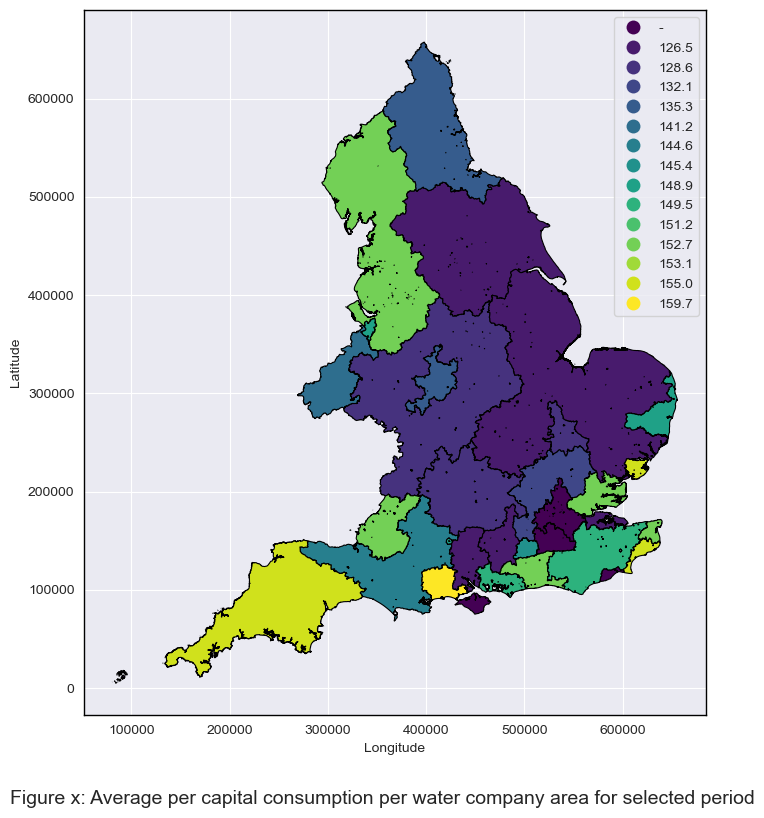

In [3]:
pcc_period ='2019-20'
chloropleth_pcc(pcc_period)

In [4]:
%run folium_pcc.py

## This section downloads the sentinel image for the water resource zone with the highest PCC

In [ ]:
# need to fix this so that the sentinel image retrieved is for the right area - I think add the folium map above 
# install sentinelsat via conda; set up netrc file for api

In [ ]:
# select water company to review in further detail:
company_detail ='Bournemouth'
download_sat_image_company.download_best_overlap_image(company_detail)
Image(filename='data_files/img.png')

To download the images, edit the download_sat_image_company module to uncomment the line to enable download. 